In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# bandwidth-delay product
def generatePackets(send_rate, bandwidth, MI):
    overflow = 0
    if send_rate<bandwidth:
        bandwidth_left = send_rate*MI
        time_zone = MI*send_rate/bandwidth
    else:
        bandwidth_left = bandwidth*MI
        overflow = (send_rate-bandwidth)*MI
        time_zone = MI
    time_left = time_zone
    send = 0
    ack = 0
    avgLatency = 0
    BLproduct = 0
    
    
    while bandwidth_left > 0:
        
        r = random.random()
        if r<0.4832:
            packet_length = 40+random.randint(0,40)
        elif r<0.8674:
            packet_length = 1480+random.randint(0,20)
        else:
            packet_length = 80+random.randint(0,1400)
            
        if packet_length > bandwidth_left:
            packet_length = bandwidth_left
            bandwidth_left = 0
            time_left = 0
        else:
            time_left = time_left*(1-(packet_length/bandwidth_left))
            bandwidth_left = bandwidth_left-packet_length
        
        r = random.random()
        if r<0.05:
            rtt = random.random()*10
        elif r<0.20:
            rtt = 10+random.random()*40
        elif r<0.45:
            rtt = 50+random.random()*50
        elif r<0.65:
            rtt = 100+random.random()*100
        elif r<0.9:
            rtt = 200+random.random()*800
        else:
            rtt = 1000+random.random()*9000
        
        send = send+1
        if rtt<=time_left:
            ack = ack+1
        
        latency = time_zone-time_left+rtt
        avgLatency = (avgLatency*(send-1)+latency)/send
    
    while overflow>0:
        r = random.random()
        if r<0.4832:
            packet_length = 40+random.randint(0,40)
        elif r<0.8674:
            packet_length = 1480+random.randint(0,20)
        else:
            packet_length = 80+random.randint(0,1400)
            
        if packet_length > overflow:
            overflow = 0
        else:
            overflow = overflow-packet_length
        
        send = send+1
    ackRatio = ack/send
    return round(avgLatency),round(ackRatio,4)

In [3]:
a = np.load("bandwidth.npy")

In [4]:
def sendRate2States(send_rate):
    if(send_rate/20 < 125):
        return send_rate//20
    else:
        return 125

In [5]:
def train():
    alpha = 0.1
    Lambda = 0.6
    gamma = 0.99
    states = range(126)
    actions = [0.5,0.4,0.3,0.2,0.1,0.0,-0.1,-0.2,-0.3,-0.4,-0.5]
    q_table = pd.DataFrame(data=[[0 for _ in actions] for _ in states], index = states, columns = actions)
    MI = 200
    time = 120000
    bandwidth = a
    send_rate = a[0]
    epsilon = 0.9
    d_send = np.zeros(round(time/MI))
    for i in range(20):
        reward = 0
        current_state = sendRate2States(send_rate)
        total_steps = 0
        while total_steps < time/MI:
            if(random.uniform(0,1) > epsilon) or ((q_table.loc[current_state]  == 0).all()):
                current_action = random.choice(actions)
            else:
                current_action = q_table.loc[current_state].idxmax()
            
            send_rate = send_rate*(1+current_action)
            if send_rate>2500:
                send_rate = 2500
            if i==19:
                d_send[total_steps] = send_rate-bandwidth[total_steps]
            next_state = sendRate2States(send_rate)
            avgLatency,ackRatio = generatePackets(send_rate, bandwidth[total_steps], MI)
            reward = Lambda*reward + send_rate -avgLatency-20*(1-ackRatio)
            penalty = 0
            if ackRatio < 0.32:
                penalty = 1000
            next_state_q_values_max = q_table.loc[next_state].idxmax()
            q_table.loc[current_state, current_action] += alpha * (reward-penalty+gamma*next_state_q_values_max - q_table.loc[current_state, current_action])
            current_state = next_state
            total_steps+=1
        epsilon = epsilon+0.05
    return d_send

In [6]:
d_send = train()

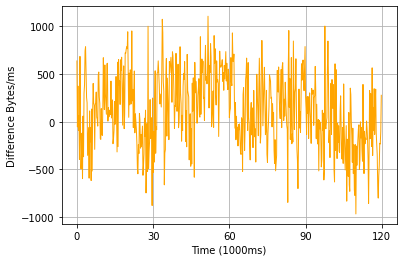

In [9]:
x = np.arange(0,120,0.2)

plt.plot(x,d_send, color='orange', linewidth=1, linestyle='-')

plt.xlabel('Time (1000ms)')
plt.ylabel('Difference Bytes/ms')

plt.xticks([0,30,60,90,120])

plt.grid()

plt.show()

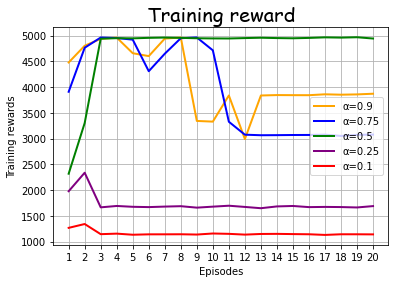

In [31]:
#rewards1 = train(0.75)
#rewards2 = train(0.5)
#rewards3 = train(0.25)
#rewards4 = train(0.1)
#rewards5 = train(0.9)

#x = np.arange(1,21,1)

#plt.plot(x,rewards5, label='α=0.9', color='orange', linewidth=2, linestyle='-')
#plt.plot(x,rewards1, label='α=0.75', color='b', linewidth=2, linestyle='-')
#plt.plot(x,rewards2, label='α=0.5', color='g', linewidth=2, linestyle='-')
#plt.plot(x,rewards3, label='α=0.25', color='purple', linewidth=2, linestyle='-')
#plt.plot(x,rewards4, label='α=0.1', color='r', linewidth=2, linestyle='-')


#plt.title('Training reward', fontdict={'fontname':'Comic Sans MS', 'fontsize':20})
#plt.xlabel('Episodes')
#plt.ylabel('Training rewards')

#plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

#plt.legend()

#plt.grid()

#plt.show()